In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
#test

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

from interpret.glassbox import ExplainableBoostingClassifier

data = load_breast_cancer()
data_X, y = data.data, data.target

In [3]:
X = pd.DataFrame(data=data_X, columns = data.feature_names)

In [4]:
X['category'] = np.where(X['mean smoothness'] <=0.1,'A','B')

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=0)

In [6]:
X_test['category']='C'

In [7]:
from scorepyo.binary_featurizer import AutomaticBinaryFeaturizer
from scorepyo.models import OptunaScoreCard

c:\Users\S5384228\Anaconda3\envs\env_scorepyo\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
binarizer = AutomaticBinaryFeaturizer(max_number_binaries_by_features=3,one_hot_encode=True,keep_negative=True)


In [9]:
binarizer.fit(X_train,y_train, categorical_features=['category'])

In [10]:
X_train_binarized, df_info = binarizer.transform(X_train, categorical_features=['category'])

X_test_binarized, _ = binarizer.transform(X_test, categorical_features=['category'])

In [11]:
df_info

,EBM_log_odds_contribution,lower_threshold,upper_threshold,feature
binary_feature,,,,
mean radius < 12.26,0.135708,NaN,12.26,mean radius
12.26 <= mean radius < 14.66,0.086529,12.26,14.66,mean radius
mean radius >= 14.66,-0.222237,14.66,NaN,mean radius
mean texture < 17.2,0.740917,NaN,17.205,mean texture
17.2 <= mean texture < 20.66,0.056726,17.205,20.665,mean texture
...,...,...,...,...
0.07 <= worst fractal dimension < 0.09,0.372596,0.07428,0.08649,worst fractal dimension
worst fractal dimension >= 0.09,-0.156302,0.08649,NaN,worst fractal dimension
category_A,None,None,None,category


In [12]:
scorepyo_model = OptunaScoreCard(nb_max_features=3, min_point_value=-1, max_point_value=2, df_info=df_info['feature'].reset_index())

scorepyo_model.fit(X_train_binarized, y_train)


In [13]:
scorepyo_model.summary()

| FEATURE-POINT CARD |
| feature           | Description              |   point |
|:------------------|:-------------------------|--------:|
| worst concavity   | worst concavity >= 0.33  |      -1 |
| worst compactness | worst compactness < 0.17 |       2 |
| worst concavity   | worst concavity < 0.15   |       2 |


|     SCORE CARD     |
| SCORE   | -1     | 0      | 1      | 2      | 3      | 4      |
|:--------|:-------|:-------|:-------|:-------|:-------|:-------|
| RISK    | 26.89% | 50.00% | 73.11% | 88.08% | 95.26% | 98.20% |


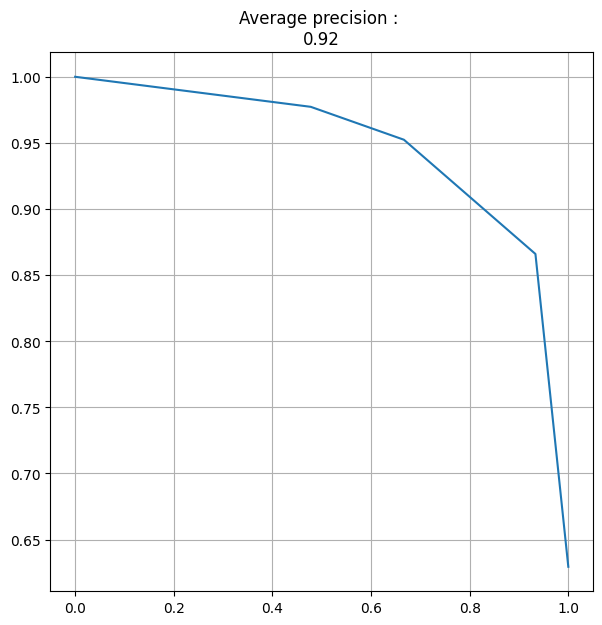

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score


y_proba = scorepyo_model.predict_proba(X_test_binarized)[:, 1].reshape(-1,1)

precision, recall, thresholds = precision_recall_curve(y_test.astype(int), y_proba)
fig, ax = plt.subplots(figsize=(7, 7))
plt.plot(recall, precision)
average_precision = np.round(average_precision_score(y_test.astype(int),y_proba),3)
title_PR_curve = f'Average precision : \n{average_precision}'
plt.title(title_PR_curve)
plt.grid()
plt.show()